In [1]:
# import of libraries
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)
session = Session(engine)

/var/folders/8t/81p4d2815lz532ljzz7cq3040000gn/T/ipykernel_4999/2198268950.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  base.prepare(engine, reflect = True)


In [6]:
# View all of the classes that automap found
base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
date_most_recent = session.query(func.max(measurement.date)).scalar()
print(date_most_recent)

2017-08-23


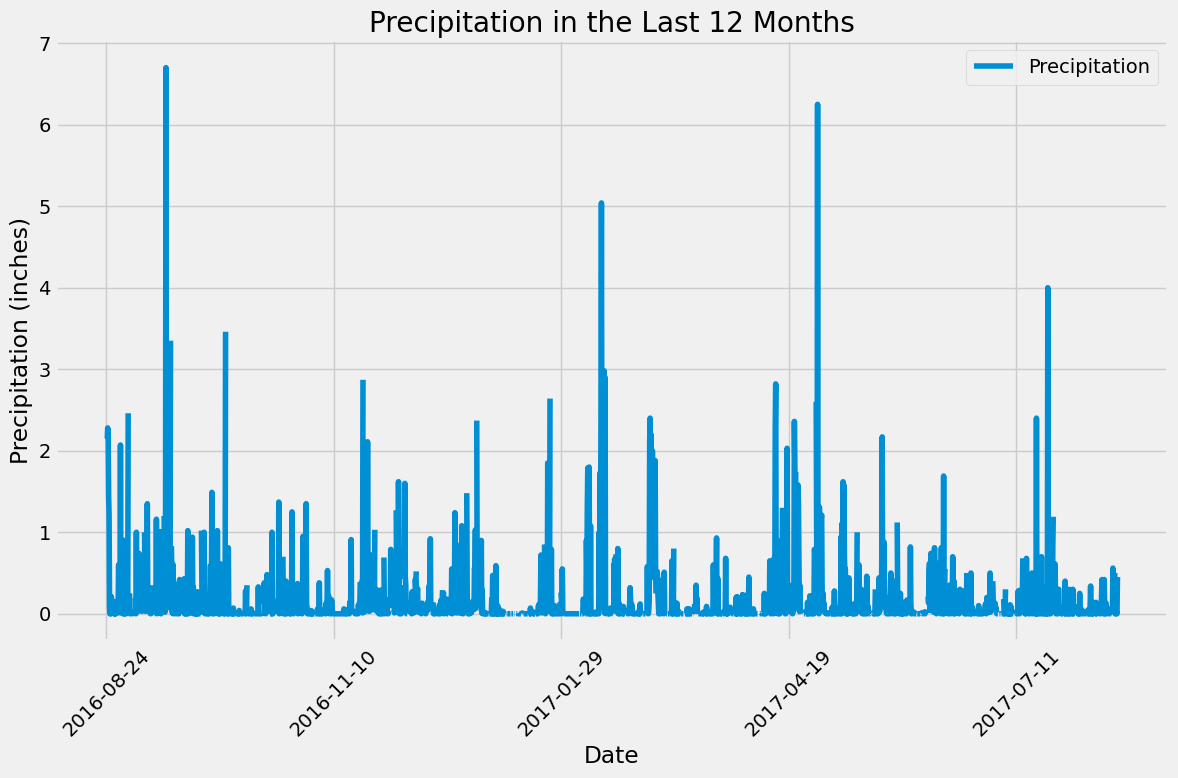

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_before = dt.datetime.strptime(date_most_recent, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_before).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', figsize=(12, 8))
plt.title("Precipitation in the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe().to_frame().round(2)
summary_stats_styled = summary_stats.style.format("{:.2f}")

print("Summary Statistics for Precipitation Data:")
summary_stats_styled

Summary Statistics for Precipitation Data:


,Precipitation
count,2015.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations_ = session.query(func.count(func.distinct(station.station))).scalar()

print(stations_)

9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
print("Most Active Station:")
for station, count in most_active:
    print(f"Station: {station}, Count: {count}")

Most Active Station:
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
most_active[0][0]

'USC00519281'

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temps = session.query(func.min(measurement.tobs),
                              func.max(measurement.tobs),
                              func.avg(measurement.tobs)).\
                        filter(measurement.station == most_active[0][0]).all()

temps = []
for row in station_temps:
    (min_temp,max_temp,avg_temp) = (row)
    temps.append(min_temp)
    temps.append(max_temp)
    temps.append(avg_temp)
print(temps)

[54.0, 85.0, 71.66378066378067]


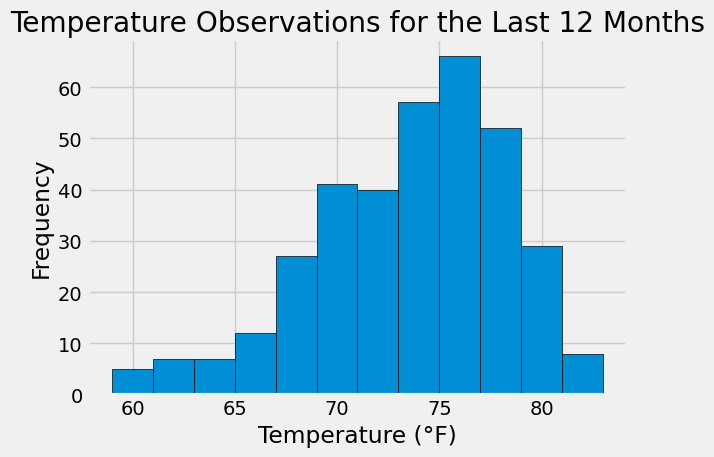

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(measurement.tobs).\
    filter(measurement.station == most_active[0][0]).\
    filter(measurement.date >= one_year_before).all()

temperatures = [temp[0] for temp in temp_results]

plt.hist(temperatures, bins=12, edgecolor='black')
plt.title("Temperature Observations for the Last 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [17]:
# Close Session
session.close()